In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd # Using version 1.2.0
from collections import Counter
import re
from scipy.stats import ttest_ind

def read_date(date):
    return xlrd.xldate.xldate_as_datetime(date, 0)

In [2]:
# Loading in the data
xlsfile = pd.read_excel('QVI_transaction_data.xlsx',sheet_name='in')
csvfile = pd.read_csv('QVI_purchase_behaviour.csv')
# Change the date column in xlsx file from integer to datetime
xlsfile['DATE']=pd.to_datetime(xlsfile['DATE'].apply(read_date),errors='coerce')

In [3]:
# Look through the chips name and see if there are any products that are not chips
xlsfile['PROD_NAME'].unique()

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

In [4]:
# dropping values that are not chips
xlsfile = xlsfile.drop(xlsfile[xlsfile.PROD_NAME.str.contains('Doritos Salsa|Woolworths Medium   Salsa|Woolworths Mild     Salsa|Old El Paso')].index).reset_index(drop=True)

#### Insight:
Using xlsfile[xlsfile.PROD_NAME.str.contains('Salsa')] drops products that are chips from our data. A more specific drop instruction is used instead, given our data is small enough. We can spend time to specifically drop values, If our data was larger using "Salsa" would be more time efficient. When calculating our data, subsequently there is not a change in insight using a general or specific drop instruction.

In [5]:
# Reviewing the data to see any anomalous value.
xlsfile.describe(include='all',datetime_is_numeric=True)

DATE      STORE_NBR  LYLTY_CARD_NBR  \
count                          249670  249670.000000    2.496700e+05   
unique                            NaN            NaN             NaN   
top                               NaN            NaN             NaN   
freq                              NaN            NaN             NaN   
mean    2018-12-30 02:25:45.201316608     135.044278    1.355203e+05   
min               2018-07-01 00:00:00       1.000000    1.000000e+03   
25%               2018-09-30 00:00:00      70.000000    7.001625e+04   
50%               2018-12-30 00:00:00     130.000000    1.303600e+05   
75%               2019-03-31 00:00:00     203.000000    2.030798e+05   
max               2019-06-30 00:00:00     272.000000    2.373711e+06   
std                               NaN      76.773591    8.065746e+04   

              TXN_ID       PROD_NBR                               PROD_NAME  \
count   2.496700e+05  249670.000000                                  249670   
unique           NaN            NaN                                     107   
top              NaN            NaN  Kettle Mozzarella   Basil & Pesto 175g   
freq             NaN            NaN                                    3304   
mean    1.351234e+05      56.294288                                     NaN   
min     1.000000e+00       1.000000                                     NaN   
25%     6.757425e+04      27.000000                                     NaN   
50%     1.351475e+05      53.000000                                     NaN   
75%     2.026338e+05      86.000000                                     NaN   
max     2.415841e+06     114.000000                                     NaN   
std     7.813155e+04      33.528758                                     NaN   

             PROD_QTY      TOT_SALES  
count   249670.000000  249670.000000  
unique            NaN            NaN  
top               NaN            NaN  
freq              NaN            NaN  
mean         1.907762       7.293966  
min          1.000000       1.700000  
25%          2.000000       5.700000  
50%          2.000000       7.400000  
75%          2.000000       8.800000  
max        200.000000     650.000000  
std          0.657126       3.071796

In [6]:
# Looking for large quilty.
xlsfile.loc[xlsfile['PROD_QTY']== 200]

DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
65786 2018-08-19        226          226000  226201         4   
65787 2019-05-20        226          226000  226210         4   

                              PROD_NAME  PROD_QTY  TOT_SALES  
65786  Dorito Corn Chp     Supreme 380g       200      650.0  
65787  Dorito Corn Chp     Supreme 380g       200      650.0

In [7]:
# Looking if the customer has made other purchases.
xlsfile.loc[xlsfile['LYLTY_CARD_NBR']== 226000]

DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
65786 2018-08-19        226          226000  226201         4   
65787 2019-05-20        226          226000  226210         4   

                              PROD_NAME  PROD_QTY  TOT_SALES  
65786  Dorito Corn Chp     Supreme 380g       200      650.0  
65787  Dorito Corn Chp     Supreme 380g       200      650.0

In [8]:
# Delete the customer from our data, since they are an anomaly in our data.
xlsfile = xlsfile.drop(xlsfile.loc[xlsfile['LYLTY_CARD_NBR']== 226000].index).reset_index(drop=True)

In [9]:
# Re-examine the data to see if there are any more anomalous values.
xlsfile.describe(include='all',datetime_is_numeric=True)

DATE      STORE_NBR  LYLTY_CARD_NBR  \
count                          249668  249668.000000    2.496680e+05   
unique                            NaN            NaN             NaN   
top                               NaN            NaN             NaN   
freq                              NaN            NaN             NaN   
mean    2018-12-30 02:25:42.502895104     135.043550    1.355196e+05   
min               2018-07-01 00:00:00       1.000000    1.000000e+03   
25%               2018-09-30 00:00:00      70.000000    7.001600e+04   
50%               2018-12-30 00:00:00     130.000000    1.303595e+05   
75%               2019-03-31 00:00:00     203.000000    2.030790e+05   
max               2019-06-30 00:00:00     272.000000    2.373711e+06   
std                               NaN      76.773467    8.065737e+04   

              TXN_ID       PROD_NBR                               PROD_NAME  \
count   2.496680e+05  249668.000000                                  249668   
unique           NaN            NaN                                     107   
top              NaN            NaN  Kettle Mozzarella   Basil & Pesto 175g   
freq             NaN            NaN                                    3304   
mean    1.351227e+05      56.294707                                     NaN   
min     1.000000e+00       1.000000                                     NaN   
25%     6.757375e+04      27.000000                                     NaN   
50%     1.351465e+05      53.000000                                     NaN   
75%     2.026322e+05      86.000000                                     NaN   
max     2.415841e+06     114.000000                                     NaN   
std     7.813144e+04      33.528566                                     NaN   

             PROD_QTY      TOT_SALES  
count   249668.000000  249668.000000  
unique            NaN            NaN  
top               NaN            NaN  
freq              NaN            NaN  
mean         1.906175       7.288817  
min          1.000000       1.700000  
25%          2.000000       5.700000  
50%          2.000000       7.400000  
75%          2.000000       8.800000  
max          5.000000      29.500000  
std          0.342744       2.475279

In [10]:
# Creating the dataframe that contains the number of purchases made in a day by consumers.
Date_count = xlsfile.groupby(['DATE']).size().to_frame('COUNT').reset_index()

# Creating dataframe that contains all of the dates from 7/01/2018 to 6/30/2019 to see what date is missing above.
Total_Time = pd.DataFrame(pd.date_range(start='7/01/2018', end='6/30/2019'), columns=['DATE'])

# Merging the two dataframes to see what day is missing.
Merge_Date = pd.merge(Date_count,Total_Time,how='right',on='DATE')

# Showing the date that is missing by the existince of the null value.
Merge_Date[Merge_Date.isna().any(axis=1)]

DATE  COUNT
177 2018-12-25    NaN

<AxesSubplot:xlabel='DATE', ylabel='COUNT'>

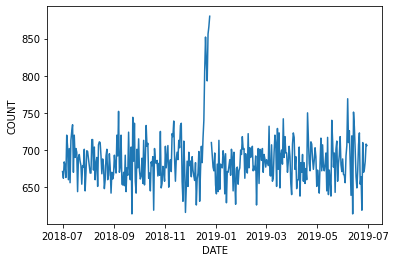

In [11]:
# Made a graph to visiualize the trends and make conclusions.
sns.lineplot(x='DATE', y='COUNT',data = Merge_Date)

We can conclude there is a huge spike of sales of chips before Christmas then stores are closed on Christmas day with a regular purchase of chips the next day.

<AxesSubplot:xlabel='PACKSIZE', ylabel='SIZES'>

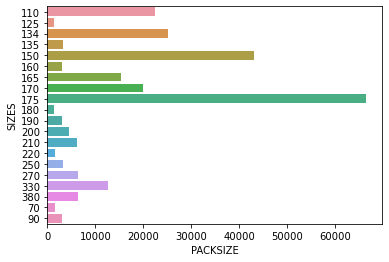

In [12]:
# Extract and count how many times certain sizes appear in PROD_NAME.
xlsfile['PACKSIZE'] = xlsfile['PROD_NAME'].str.extract(r'(\d+[.\d]*)')
packsize_info = pd.DataFrame(xlsfile['PACKSIZE'].value_counts()).rename_axis('SIZES').reset_index()
packsize_info.sort_values(by=['SIZES'], inplace=True)
sns.barplot(y = 'SIZES', x = 'PACKSIZE',data = packsize_info)

In [13]:
# Replacing words that are spelled differently to get a accurate count of all the products brand names.
xlsfile['BRAND_NAME'] = xlsfile['PROD_NAME'].str.split(' ').str[0].replace('Red','RRD').replace('Snbts','Sunbites').replace('Infzns','Infuzions').replace('WW','Woolworths').replace('Smith','Smiths').replace('NCC','Natural').replace('Grain','GrnWves').replace('Dorito','Doritos')
xlsfile['BRAND_NAME'].value_counts()

Kettle        41288
Smiths        31823
Doritos       25224
Pringles      25102
RRD           17779
Infuzions     14201
Thins         14075
Woolworths    11836
Cobs           9693
Tostitos       9471
Twisties       9454
GrnWves        7740
Natural        7469
Tyrrells       6442
Cheezels       4603
CCs            4551
Sunbites       3008
Cheetos        2927
Burger         1564
French         1418
Name: BRAND_NAME, dtype: int64

In [14]:
# Count all the total of different LIFESTAGE's.
Lifestage_numb = pd.DataFrame(csvfile['LIFESTAGE'].value_counts().to_frame('COUNT').reset_index()).rename(columns={'index':'LIFESTAGE'})
Lifestage_numb

LIFESTAGE  COUNT
0                RETIREES  14805
1   OLDER SINGLES/COUPLES  14609
2   YOUNG SINGLES/COUPLES  14441
3          OLDER FAMILIES   9780
4          YOUNG FAMILIES   9178
5  MIDAGE SINGLES/COUPLES   7275
6            NEW FAMILIES   2549

In [15]:
# Count the total of different PREMIUM_CUSTOMER.
Customer_type = pd.DataFrame(csvfile['PREMIUM_CUSTOMER'].value_counts().to_frame('COUNT').reset_index()).rename(columns={'index':'PREMIUM_CUSTOMER'})
Customer_type

PREMIUM_CUSTOMER  COUNT
0       Mainstream  29245
1           Budget  24470
2          Premium  18922

In [16]:
# Combine our two data.
data_comb = pd.merge(xlsfile,csvfile,on='LYLTY_CARD_NBR')
data_comb

DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0      2018-10-17          1            1000       1         5   
1      2019-05-14          1            1307     348        66   
2      2018-11-10          1            1307     346        96   
3      2019-03-09          1            1307     347        54   
4      2019-05-20          1            1343     383        61   
...           ...        ...             ...     ...       ...   
249663 2019-03-09        272          272319  270088        89   
249664 2018-08-13        272          272358  270154        74   
249665 2018-11-06        272          272379  270187        51   
249666 2018-12-27        272          272379  270188        42   
249667 2018-09-22        272          272380  270189        74   

                                      PROD_NAME  PROD_QTY  TOT_SALES PACKSIZE  \
0        Natural Chip        Compny SeaSalt175g         2        6.0      175   
1                      CCs Nacho Cheese    175g         3        6.3      175   
2                WW Original Stacked Chips 160g         2        3.8      160   
3                             CCs Original 175g         1        2.1      175   
4        Smiths Crinkle Cut  Chips Chicken 170g         2        2.9      170   
...                                         ...       ...        ...      ...   
249663  Kettle Sweet Chilli And Sour Cream 175g         2       10.8      175   
249664            Tostitos Splash Of  Lime 175g         1        4.4      175   
249665                 Doritos Mexicana    170g         2        8.8      170   
249666  Doritos Corn Chip Mexican Jalapeno 150g         2        7.8      150   
249667            Tostitos Splash Of  Lime 175g         2        8.8      175   

        BRAND_NAME               LIFESTAGE PREMIUM_CUSTOMER  
0          Natural   YOUNG SINGLES/COUPLES          Premium  
1              CCs  MIDAGE SINGLES/COUPLES           Budget  
2       Woolworths  MIDAGE SINGLES/COUPLES           Budget  
3              CCs  MIDAGE SINGLES/COUPLES           Budget  
4           Smiths  MIDAGE SINGLES/COUPLES           Budget  
...            ...                     ...              ...  
249663      Kettle   YOUNG SINGLES/COUPLES          Premium  
249664    Tostitos   YOUNG SINGLES/COUPLES          Premium  
249665     Doritos   YOUNG SINGLES/COUPLES          Premium  
249666     Doritos   YOUNG SINGLES/COUPLES          Premium  
249667    Tostitos   YOUNG SINGLES/COUPLES          Premium  

[249668 rows x 12 columns]

In [17]:
# Show if there are any null value in LIFESTAGE column. It appears there are not any.
data_comb['LIFESTAGE'].isna().value_counts()

False    249668
Name: LIFESTAGE, dtype: int64

In [18]:
# Show if there are any null value in PREMIUM_CUSTOMER column. It appears there are not any.
data_comb['PREMIUM_CUSTOMER'].isna().value_counts()

False    249668
Name: PREMIUM_CUSTOMER, dtype: int64

# Data Analysis on customer segments
Data is ready for analysis

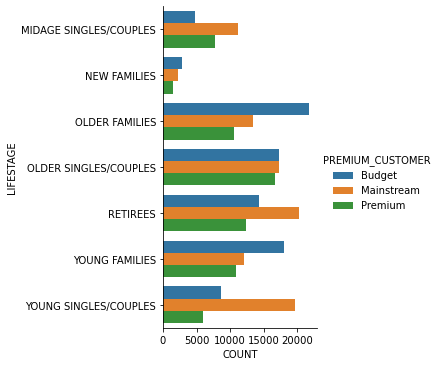

In [19]:
# Counts how many customers are in different type's of memberships and within that in what LIFESTAGE they are in.
driver_of_sales = (data_comb.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).size().to_frame('COUNT').reset_index())
# Plotting the data.
sns.catplot(data=driver_of_sales, kind="bar",y="LIFESTAGE", x="COUNT", hue="PREMIUM_CUSTOMER")

Sales are coming mainly from Budget "OLDER FAMILIES", Mainstream "YOUNG SINGLES/COUPLES", and Mainstream "RETIREES".

In [20]:
# Look at the percentage each PREMIUM_CUSTOMER contribute in each LIFESTAGE.
LIFESTAGE_Percentage=driver_of_sales.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({'COUNT': 'sum'})
LIFESTAGE_Percentage.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).round(1)

COUNT
LIFESTAGE              PREMIUM_CUSTOMER       
MIDAGE SINGLES/COUPLES Budget             20.1
                       Mainstream         47.3
                       Premium            32.6
NEW FAMILIES           Budget             43.4
                       Mainstream         33.6
                       Premium            23.0
OLDER FAMILIES         Budget             47.7
                       Mainstream         29.3
                       Premium            23.0
OLDER SINGLES/COUPLES  Budget             33.8
                       Mainstream         33.6
                       Premium            32.6
RETIREES               Budget             30.6
                       Mainstream         43.0
                       Premium            26.4
YOUNG FAMILIES         Budget             43.9
                       Mainstream         29.5
                       Premium            26.6
YOUNG SINGLES/COUPLES  Budget             25.3
                       Mainstream         57.4
                       Premium            17.2

In [21]:
# Look at the percentage each LIFESTAGE contribute in each PREMIUM_CUSTOMER.
PREMIUM_CUSTOMER_Percentage=driver_of_sales.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).agg({'COUNT': 'sum'})
PREMIUM_CUSTOMER_Percentage.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).round(1)

COUNT
PREMIUM_CUSTOMER LIFESTAGE                    
Budget           MIDAGE SINGLES/COUPLES    5.4
                 NEW FAMILIES              3.2
                 OLDER FAMILIES           24.8
                 OLDER SINGLES/COUPLES    19.8
                 RETIREES                 16.4
                 YOUNG FAMILIES           20.5
                 YOUNG SINGLES/COUPLES     9.9
Mainstream       MIDAGE SINGLES/COUPLES   11.7
                 NEW FAMILIES              2.3
                 OLDER FAMILIES           14.0
                 OLDER SINGLES/COUPLES    18.0
                 RETIREES                 21.0
                 YOUNG FAMILIES           12.6
                 YOUNG SINGLES/COUPLES    20.5
Premium          MIDAGE SINGLES/COUPLES   11.8
                 NEW FAMILIES              2.3
                 OLDER FAMILIES           16.0
                 OLDER SINGLES/COUPLES    25.5
                 RETIREES                 18.8
                 YOUNG FAMILIES           16.6
                 YOUNG SINGLES/COUPLES     9.0

In [22]:
avg_number=data_comb.groupby(['LIFESTAGE','PREMIUM_CUSTOMER',]).mean()
avg_number['PROD_QTY']

LIFESTAGE               PREMIUM_CUSTOMER
MIDAGE SINGLES/COUPLES  Budget              1.892363
                        Mainstream          1.911875
                        Premium             1.891130
NEW FAMILIES            Budget              1.855286
                        Mainstream          1.856366
                        Premium             1.861406
OLDER FAMILIES          Budget              1.945387
                        Mainstream          1.948550
                        Premium             1.945572
OLDER SINGLES/COUPLES   Budget              1.914327
                        Mainstream          1.911206
                        Premium             1.913989
RETIREES                Budget              1.893066
                        Mainstream          1.886645
                        Premium             1.901116
YOUNG FAMILIES          Budget              1.941428
                        Mainstream          1.941259
                        Premium             1.937540
YOUNG

It appears "OLDER FAMILIES" and "YOUNG FAMILIES" are the highest customers with average number of units per customer.

In [23]:
AVG_MEAN=data_comb.groupby(['LIFESTAGE','PREMIUM_CUSTOMER',]).mean()
LIFESTAGE_AVG_MEAN=pd.DataFrame(AVG_MEAN['TOT_SALES']/AVG_MEAN['PROD_QTY'])
LIFESTAGE_AVG_MEAN.columns=['MEAN']
LIFESTAGE_AVG_MEAN

MEAN
LIFESTAGE              PREMIUM_CUSTOMER          
MIDAGE SINGLES/COUPLES Budget            3.737155
                       Mainstream        3.981822
                       Premium           3.763322
NEW FAMILIES           Budget            3.922009
                       Mainstream        3.924335
                       Premium           3.869505
OLDER FAMILIES         Budget            3.733175
                       Mainstream        3.722671
                       Premium           3.703236
OLDER SINGLES/COUPLES  Budget            3.875551
                       Mainstream        3.808138
                       Premium           3.884130
RETIREES               Budget            3.920499
                       Mainstream        3.839239
                       Premium           3.910686
YOUNG FAMILIES         Budget            3.747397
                       Mainstream        3.707091
                       Premium           3.745940
YOUNG SINGLES/COUPLES  Budget            3.672790
                       Mainstream        4.063031
                       Premium           3.681847

Observe Mainstream "MIDAGE SINGLES/COUPLES" and "YOUNG SINGLES/COUPLES" are more willing to pay more per pack of chips compared to their budget and premium equivalents.

In [24]:
# Make a copy of the data_comb with more specific column to use for statistical analysis.
new = data_comb[['LIFESTAGE', 'PROD_QTY', 'PREMIUM_CUSTOMER','TOT_SALES']].copy()

In [25]:
# Look specify at Mainstream MIDAGE SINGLES/COUPLES and YOUNG SINGLES/COUPLES.
Mainstream_LIFESTAGE = new[new['LIFESTAGE'].isin(['MIDAGE SINGLES/COUPLES','YOUNG SINGLES/COUPLES']) & new['PREMIUM_CUSTOMER'].str.match('Mainstream')]
# Calculate the TOT_SALES/PROD_QTY of each Customer.
Mainstream_LIFESTAGE_PROD = Mainstream_LIFESTAGE['TOT_SALES']/Mainstream_LIFESTAGE['PROD_QTY']

In [26]:
# Look specify at MIDAGE SINGLES/COUPLES and YOUNG SINGLES/COUPLES that are not Mainstream members.
NOT_Mainstream_LIFESTAGE=new[new['LIFESTAGE'].isin(['MIDAGE SINGLES/COUPLES','YOUNG SINGLES/COUPLES']) & ~new['PREMIUM_CUSTOMER'].str.match('Mainstream')]
# Calculate the TOT_SALES/PROD_QTY of each Customer.
NOT_Mainstream_LIFESTAGE_PROD=NOT_Mainstream_LIFESTAGE['TOT_SALES']/NOT_Mainstream_LIFESTAGE['PROD_QTY']

In [27]:
# Finding the t-test and the p-value.
t,p=ttest_ind(Mainstream_LIFESTAGE_PROD,NOT_Mainstream_LIFESTAGE_PROD,equal_var=False)
if p <0.05:
  print("we reject null hypothesis")
else:
  print("we accept null hypothesis")

we reject null hypothesis


The unit price for mainstream "MIDAGE SINGLES/COUPLES" and "YOUNG SINGLES/COUPLES" are significantly higher than that of Budget or Premium "MIDAGE SINGLES/COUPLES" and "YOUNG SINGLES/COUPLES".

# Elicitation of specific customer segments

In [28]:
# Creating a dataframe with only YOUNG SINGLES/COUPLES with Mainstream membership information.
Y_S_C=data_comb[data_comb['LIFESTAGE'].str.match('YOUNG SINGLES/COUPLES') & data_comb['PREMIUM_CUSTOMER'].str.match('Mainstream')]
Y_S_C_sum=Y_S_C['PROD_QTY'].sum()

# Creating a dataframe with everyting excluding YOUNG SINGLES/COUPLES with Mainstream membership information.
OTHER_CUSTOMERS=data_comb[~(data_comb['LIFESTAGE'].str.match('YOUNG SINGLES/COUPLES') & data_comb['PREMIUM_CUSTOMER'].str.match('Mainstream'))]
OTHER_CUSTOMERS_sum=OTHER_CUSTOMERS['PROD_QTY'].sum()

# Finding the what Brand name is popular amongest the YOUNG SINGLES/COUPLES compared to the others.
Y_S_C_by_brand=pd.DataFrame(Y_S_C['BRAND_NAME'].value_counts()/Y_S_C_sum).rename_axis('BRAND').reset_index()
OTHER_CUSTOMERS_by_brand=pd.DataFrame(OTHER_CUSTOMERS['BRAND_NAME'].value_counts()/OTHER_CUSTOMERS_sum).rename_axis('BRAND').reset_index()
brand_proportions=pd.merge(Y_S_C_by_brand,OTHER_CUSTOMERS_by_brand,how ='right',on='BRAND')
brand_proportions['affinityToBrand']=brand_proportions['BRAND_NAME_x']/brand_proportions['BRAND_NAME_y']
brand_proportions.sort_values(by=['affinityToBrand'], ascending=False)

BRAND  BRAND_NAME_x  BRAND_NAME_y  affinityToBrand
13    Tyrrells      0.016955      0.013252         1.279399
10    Twisties      0.024651      0.019467         1.266296
2      Doritos      0.065162      0.051991         1.253330
9     Tostitos      0.024378      0.019529         1.248286
0       Kettle      0.105289      0.085216         1.235558
3     Pringles      0.063409      0.051859         1.222717
8         Cobs      0.023665      0.020093         1.177780
5    Infuzions      0.034238      0.029474         1.161633
11     GrnWves      0.017694      0.016145         1.095982
6        Thins      0.031937      0.029379         1.087096
15    Cheezels      0.009477      0.009688         0.978216
1       Smiths      0.054452      0.067899         0.801959
17     Cheetos      0.004547      0.006284         0.723609
19      French      0.002136      0.003050         0.700571
4          RRD      0.026541      0.038257         0.693774
12     Natural      0.010792      0.016101         0.670242
14         CCs      0.006081      0.009852         0.617202
16    Sunbites      0.003506      0.006554         0.534909
7   Woolworths      0.013120      0.025846         0.507614
18      Burger      0.001698      0.003418         0.496803

Mainstream "YOUNG SINGLES/COUPLES" are ~27% more likely to purchase Tyrrells compared to the other customers.

Mainstream "YOUNG SINGLES/COUPLES" are ~51% less likely to purchase Burger compared to the other customers.

In [29]:
# Finding the what Pack size is popular amongest the YOUNG SINGLES/COUPLES compared to the others.
Y_S_C_BY_PACK=pd.DataFrame(Y_S_C['PACKSIZE'].value_counts()/Y_S_C_sum).rename_axis('SIZE').reset_index()
Y_S_C_BY_PACK.columns=['SIZE', 'PACK_SIZE']
OTHER_CUSTOMERS_BY_PACK=pd.DataFrame(OTHER_CUSTOMERS['PACKSIZE'].value_counts()/OTHER_CUSTOMERS_sum).rename_axis('BRAND').reset_index()
OTHER_CUSTOMERS_BY_PACK.columns=['SIZE', 'PACK_SIZE']
SIZE_PROPORTIONS=pd.merge(Y_S_C_BY_PACK,OTHER_CUSTOMERS_BY_PACK,how ='right',on='SIZE')
SIZE_PROPORTIONS['affinityToPack']=SIZE_PROPORTIONS['PACK_SIZE_x']/SIZE_PROPORTIONS['PACK_SIZE_y']
SIZE_PROPORTIONS.sort_values(by=['affinityToPack'], ascending=False)

SIZE  PACK_SIZE_x  PACK_SIZE_y  affinityToPack
9   270     0.016982     0.012893        1.317207
7   380     0.017146     0.013177        1.301241
6   330     0.032732     0.025819        1.267726
2   134     0.063409     0.051859        1.222717
8   210     0.015777     0.012963        1.217067
3   110     0.056178     0.046281        1.213842
11  135     0.007943     0.006752        1.176366
12  250     0.007669     0.006575        1.166467
4   170     0.043140     0.041893        1.029760
0   175     0.136870     0.139719        0.979609
1   150     0.088773     0.090782        0.977861
5   165     0.030184     0.032305        0.934347
14  190     0.004054     0.006479        0.625657
18  180     0.001917     0.003182        0.602633
15  160     0.003506     0.006468        0.542061
13   90     0.003506     0.006554        0.534909
17   70     0.001726     0.003286        0.525092
19  125     0.001616     0.003175        0.509026
10  200     0.004903     0.009772        0.501710
16  220     0.001698     0.003418        0.496803

Mainstream "YOUNG SINGLES/COUPLES" are ~31% more likely to purchase a 270g pack of chips compared to others.

In [30]:
# We want to know what chip has 270g.
data_comb.loc[data_comb['PACKSIZE']=='270']['PROD_NAME'].unique()

array(['Twisties Cheese     270g', 'Twisties Chicken270g'], dtype=object)

# Conclusion

Sales have mainly been due to Budget "OLDER FAMIlIES", Mainstream "YOUNG SINGLES/COUPLES" and "RETIREES" shoppers. 

Mainstream "YOUNG SINGLES/COUPLES" and "RETIREES" high spending is due to more of these types of buyers. 

Mainstream "MIDAGE SINGLES/COUPLES" and "YOUNG SINGLES/COUPLES" are more likely to pay more per packet of chips. This is indicative of impulsive buying.

Mainstream "YOUNG SINGLES/COUPLES" are more likely to purchase Tyrrells chips compared to the other customers. 

Mainstream "YOUNG SINGLES/COUPLES" are less likely to purchase Tyrrells chips compared to the other customers.

We would recommend an increase in Tyrrells brand chips in locations near "YOUNG SINGLES/COUPLES" frequent would be recommended. Increasing visibility would facilitate more profit, because of their impulse behavior.